In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import transforms
import numpy as np

import matplotlib.pyplot as plt
from torchview import draw_graph
import graphviz

In [2]:
class AddNormalNoise:
    def __init__(self, alpha=0.5):
        self.alpha = torch.tensor(alpha)

    def __call__(self, tensor):
        beta = 1 - self.alpha
        noise = torch.randn_like(tensor)
        return self.alpha * tensor + beta * noise

    def __repr__(self):
        return self.__class__.__name__ + f"(mean={self.mean}, std={self.std})"

In [3]:
batch_size = 64

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
])

data_transform = transforms.Compose(data_transforms)
train_set = torchvision.datasets.FashionMNIST("data", download=True, train=True, transform=data_transforms)
test_set = torchvision.datasets.FashionMNIST("data", download=True, train=False, transform=data_transforms)
data = torch.utils.data.ConcatDataset([train_set, test_set])

dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
data = iter(dataloader)
data = next(data)[0]

In [5]:
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1):
        super(DownBlock, self).__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ]

        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X)

In [6]:
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1, strideT=2, out_paddingT=1):
        super(UpBlock, self).__init__()
        # 2 * in_chs for concatednated skip connection
        layers = [
            nn.ConvTranspose2d(2 * in_ch, out_ch, kernel_size, strideT, padding, out_paddingT),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        ]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [7]:
class UNet(nn.Module):
    def __init__(self, img_ch, img_size):
        super(UNet, self).__init__()
        down_chs = (16, 32, 64)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = img_size // 4 # 2 ** (len(down_chs) - 1)

        # Inital convolution
        self.down0 = nn.Sequential(
            nn.Conv2d(img_ch, down_chs[0], 3, padding=1),
            nn.BatchNorm2d(down_chs[0]),
            nn.ReLU()
        )

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1])
        self.down2 = DownBlock(down_chs[1], down_chs[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())
        
        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            nn.Conv2d(up_chs[0], up_chs[0], 3, padding=1),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU(),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1])
        self.up2 = UpBlock(up_chs[1], up_chs[2])

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.BatchNorm2d(up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_ch, 3, 1, 1),
        )

    def forward(self, x):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0, down2)
        up2 = self.up2(up1, down1)
        return self.out(up2)

In [8]:
unet = UNet(img_ch=1, img_size=28).to('cpu')

In [9]:
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"
def u_net_visual_explainer(batch_size, img_ch, img_size, fontname="Helvetica"):
    graphviz.set_jupyter_format('png')
    model_graph = draw_graph(
        unet,
        input_size=(batch_size, img_ch, img_size, img_size),
        device='meta',
        expand_nested=True
    )
    model_graph.visual_graph.node_attr["fontname"] = fontname
    model_graph.resize_graph(scale=1.5)
    return model_graph.visual_graph

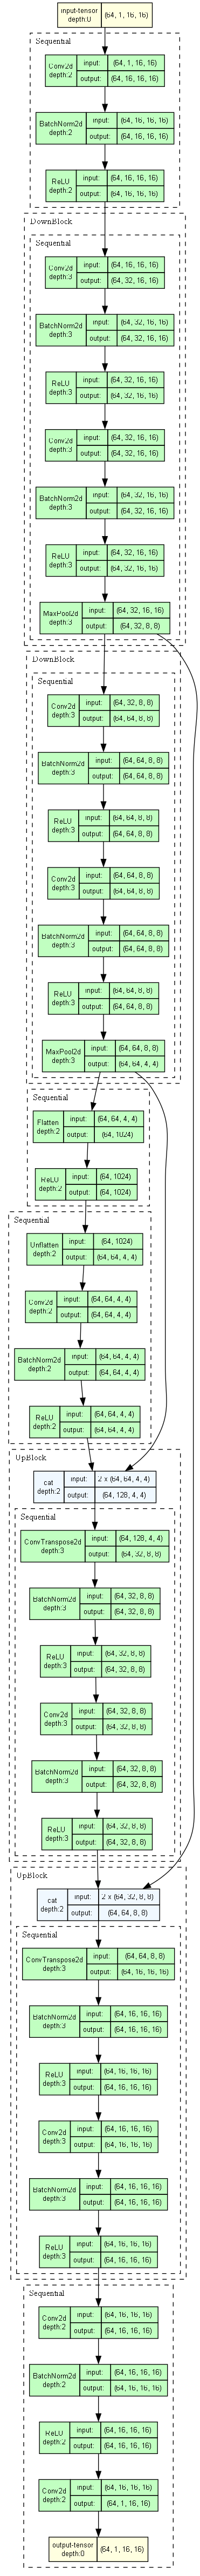

In [57]:
u_net_visual_explainer(64, 1, 16)

In [10]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image[0].detach().cpu()))

In [11]:
def plot_sample(imgs, noisy_imgs, pred_imgs):
    # Take first image of batch
    img = imgs[[0], :, :, :]
    noisy_img = noisy_imgs[[0], :, :, :]
    pred_img = pred_imgs[[0], :, :, :]

    nrows = 1
    ncols = 3
    samples = {
        "Original" : img,
        "Noise Added" : noisy_img,
        "Predicted Original" : pred_img
    }
    for i, (title, img) in enumerate(samples.items()):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(title)
        show_tensor_image(img)
    plt.show()

Epoch 1 | Step: 150 | Loss: 0.07736056298017502


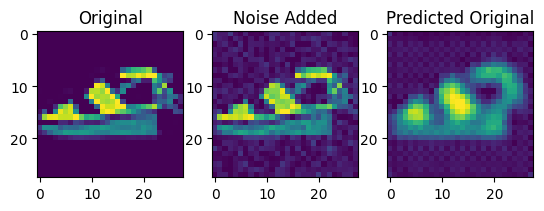

Epoch 1 | Step: 300 | Loss: 0.08644289523363113


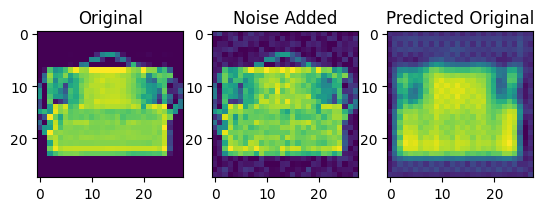

Epoch 1 | Step: 450 | Loss: 0.0960402563214302


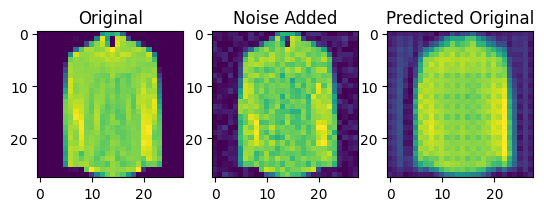

Epoch 1 | Step: 600 | Loss: 0.16803111135959625


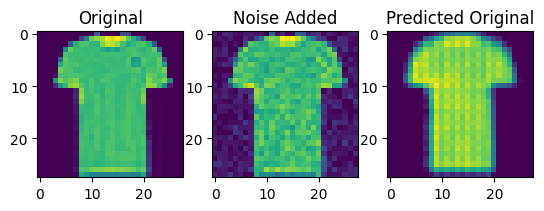

Epoch 1 | Step: 750 | Loss: 0.11992715299129486


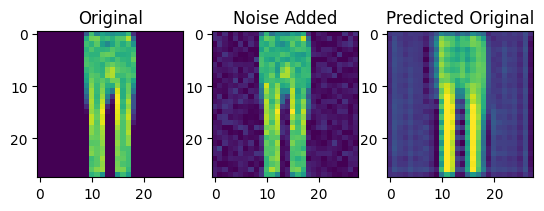

Epoch 1 | Step: 900 | Loss: 0.07525646686553955


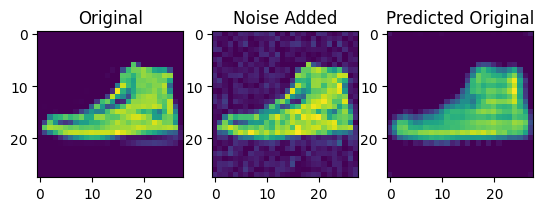

Epoch 1 | Step: 1050 | Loss: 0.10375597327947617


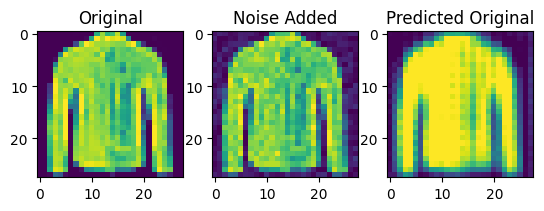

Per Epoch Loss: 0.001650367277299036
Epoch 2 | Step: 150 | Loss: 0.13193126022815704


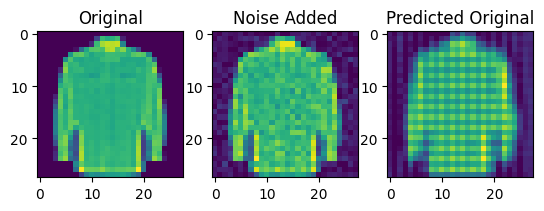

Epoch 2 | Step: 300 | Loss: 0.05426270514726639


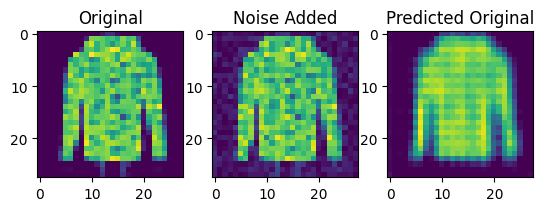

Epoch 2 | Step: 450 | Loss: 0.1067357137799263


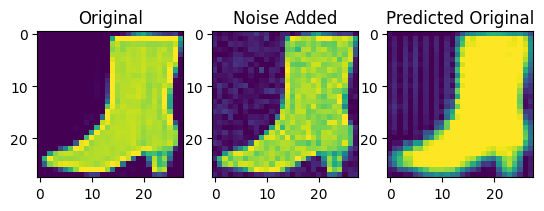

Epoch 2 | Step: 600 | Loss: 0.07311630249023438


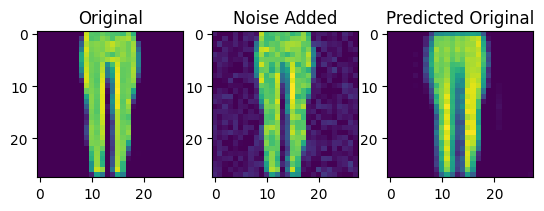

Epoch 2 | Step: 750 | Loss: 0.06701260805130005


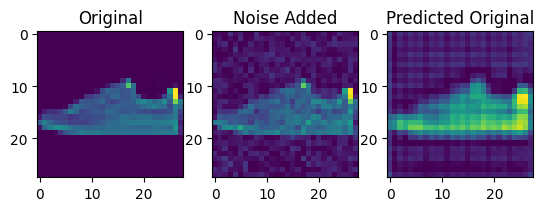

Epoch 2 | Step: 900 | Loss: 0.07781422883272171


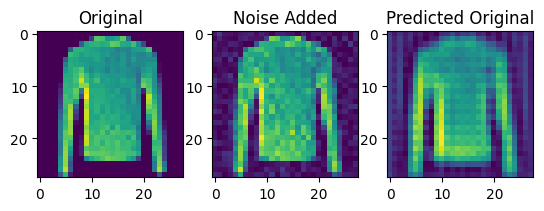

Epoch 2 | Step: 1050 | Loss: 0.06078392267227173


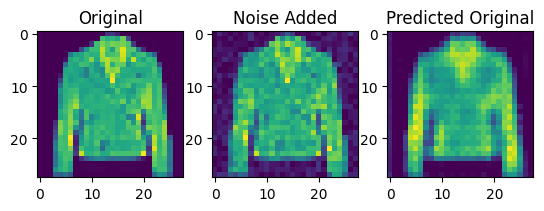

Per Epoch Loss: 0.0012844541686955987


In [236]:
epochs = 2
device = 'cpu'
optimizer = optim.Adam(unet.parameters(), lr=0.0001)

unet.train()
for epoch in range(epochs):
    running_loss = 0
    total = 0
    for batch, (inputs, _) in enumerate(dataloader, 1):
        imgs = inputs.to(device)
        imgs_noisy = add_noise(imgs)
        imgs_pred = unet(imgs_noisy)

        loss = F.mse_loss(imgs, imgs_pred)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total += inputs.size(0)

        per_epoch_loss  = running_loss / total
        
        if (batch % 150) == 0:
            print(f"Epoch {epoch+1} | Step: {batch} | Loss: {loss.item()}")
            plot_sample(imgs, imgs_noisy, imgs_pred)

    print(f"Per Epoch Loss: {per_epoch_loss}")

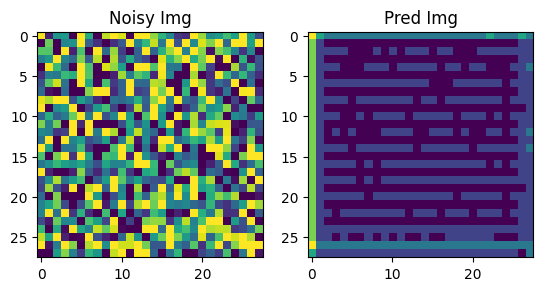

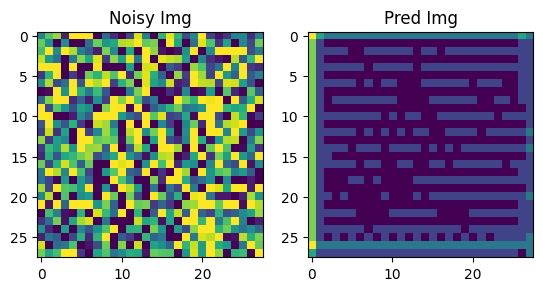

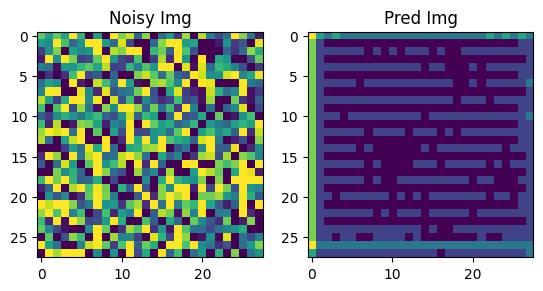

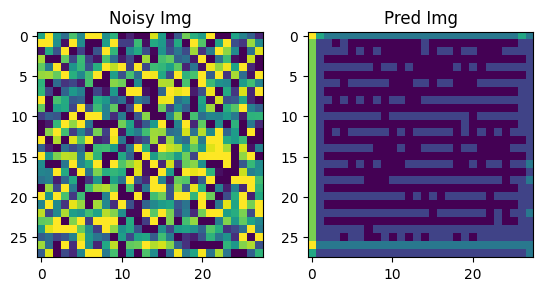

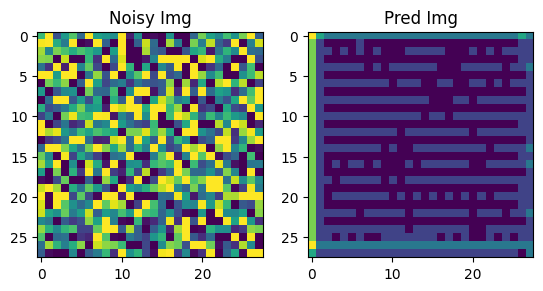

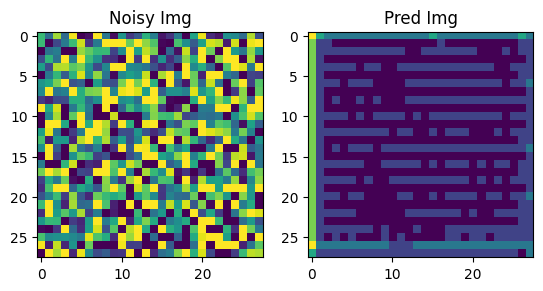

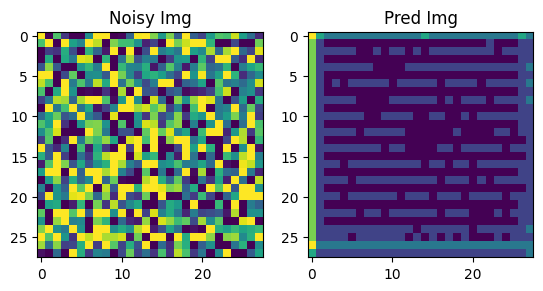

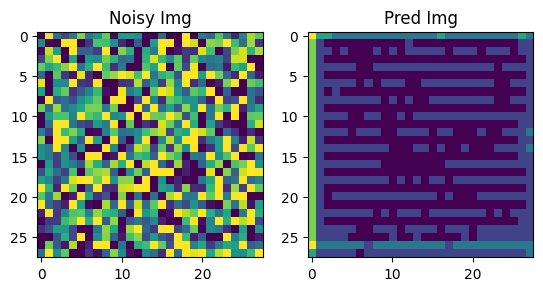

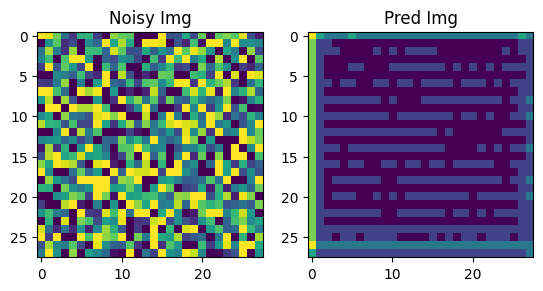

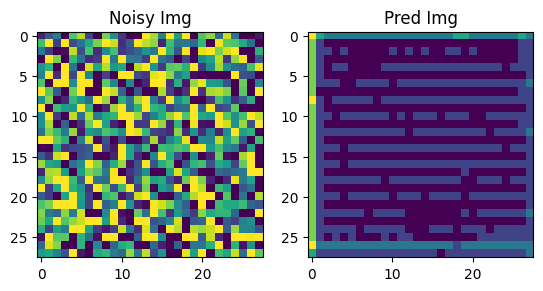

In [15]:
unet.eval()
nrows = 1
ncols = 2
for i in range(10):
    random_img = torch.randn([1, 1, 28, 28])
    pred_img = unet(random_img)

    plot_dict = {
        "Noisy Img": random_img,
        "Pred Img": pred_img
    }

    for j, (title, img) in enumerate(plot_dict.items()):
        ax = plt.subplot(nrows, ncols, j+1)
        ax.set_title(title)
        show_tensor_image(img)
    plt.show()

In [ ]:
# Findings

# U-Net Architecture is surprisingly too good to be true
# Model trained even for 2 epochs, yields a good training loss
# Clearly the model is overfitting
# This can be conformed via evaluation, it does output patterns but nothing like fashion
# Evaluating completely untrained model on random noise image shows that model can output
# Tekris like patterns, which is amusing for me, because the output literally follows some pattern.